In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas as pd
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

## Q1 Exploration of the Whole Dataset

### (a)

In [3]:
# Show the structure of the GNCHD data
! hdfs dfs -ls /data/ghcnd

Found 5 items
drwxr-xr-x   - jsw93 jsw93          0 2024-08-21 12:34 /data/ghcnd/daily
-rw-r--r--   8 jsw93 jsw93       3659 2024-08-13 14:44 /data/ghcnd/ghcnd-countries.txt
-rw-r--r--   8 jsw93 jsw93   34791732 2024-08-13 14:44 /data/ghcnd/ghcnd-inventory.txt
-rw-r--r--   8 jsw93 jsw93       1086 2024-08-13 14:44 /data/ghcnd/ghcnd-states.txt
-rw-r--r--   8 jsw93 jsw93   11007484 2024-08-13 14:44 /data/ghcnd/ghcnd-stations.txt


### (b)

In [4]:
# Show the structure of daily part and export to txt file for fulture analysis
! hdfs dfs -ls /data/ghcnd/daily > ../supplementary/daily_folder_info.txt

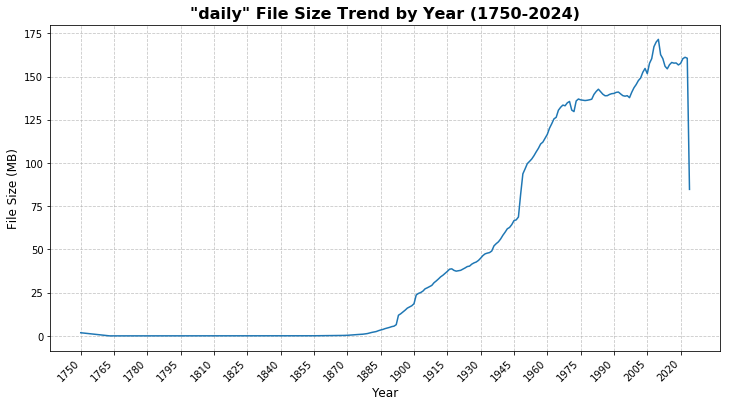

In [6]:
# Load the daily file structure data and make a plot 
daily_folder_info_path = "../supplementary/daily_folder_info.txt"
with open(daily_folder_info_path, 'r') as file:
    lines = file.readlines()[1:]
daily_year_size = []
daily_year = []
for line in lines:
    # file size of daily transfer to MB, and save to list
    daily_year_size.append(int(line[27:38].strip())/1024/1024)
    # daily year save to list
    daily_year.append(int(line[-12:-8].strip()))
    
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_year, daily_year_size)
# Set title
ax.set_title('"daily" File Size Trend by Year (1750-2024)', fontsize=16, fontweight='bold')
# Set x-axis label
ax.set_xlabel('Year', fontsize=12)
# Set y-axis label
ax.set_ylabel('File Size (MB)', fontsize=12)
# Adjust x-axis ticks
ax.set_xticks(range(1750, 2024, 15))  # Show a tick every 15 years
plt.xticks(rotation=45, ha='right')
# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)
plt.savefig('../supplementary/historical_file_size_trend.png', dpi=300, bbox_inches='tight')

plt.show()

### (c)

In [6]:
# Explore the different file size in GHCND
! hdfs dfs -du /data/ghcnd

13348547980  106788383840  /data/ghcnd/daily
3659         29272         /data/ghcnd/ghcnd-countries.txt
34791732     278333856     /data/ghcnd/ghcnd-inventory.txt
1086         8688          /data/ghcnd/ghcnd-states.txt
11007484     88059872      /data/ghcnd/ghcnd-stations.txt


## Q2 Data Exploration

In [16]:
start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)

spark.dynamicAllocation.enabled,false
spark.app.startTime,1724728115745
spark.sql.warehouse.dir,file:/users/home/ywa286/Assignment1/notebook/spark-warehouse
spark.ui.port,4682
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.driver.port,43183
spark.driver.memory,1g
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.app.name,ywa286 (jupyter)
spark.app.id,app-20240827150836-1323


### (b)

In [17]:
# Define schma for Daily
daily_schema = StructType([
    StructField("ID", StringType(), nullable=False),
    StructField("DATE", StringType(), nullable=False),
    StructField("ELEMENT", StringType(), nullable=False),
    StructField("VALUE", FloatType(), nullable=False),
    StructField("MEASUREMENT_FLAG", StringType(), nullable=True),
    StructField("QUALITY_FLAG", StringType(), nullable=True),
    StructField("SOURCE_FLAG", StringType(), nullable=True),
    StructField("OBSERVATION_TIME", StringType(), nullable=True)
])

### (c)

In [20]:
# Read 1000 rows of 2023 daily file
daily_df = spark.read.format("csv") \
    .option("header", "false") \
    .option("sep", ",") \
    .schema(daily_schema) \
    .load("hdfs:///data/ghcnd/daily/2023.csv.gz") \
    .limit(1000)

# Parse the DATE column
daily_df = daily_df.withColumn("DATE", F.to_date(F.col("DATE"), "yyyyMMdd"))

# Parse the OBSERVATION_TIME column
daily_df = daily_df.withColumn("OBSERVATION_TIME", 
    F.to_timestamp(F.concat(F.lit("1970-01-01 "), F.col("OBSERVATION_TIME")), "yyyy-MM-dd HHmm"))
daily_df = daily_df.withColumn("OBSERVATION_TIME", 
    F.date_format(F.col("OBSERVATION_TIME"), "HH:mm"))

# show the sample of data and print the schema
show_as_html(daily_df)
daily_df.printSchema()

,ID,DATE,ELEMENT,VALUE,MEASUREMENT_FLAG,QUALITY_FLAG,SOURCE_FLAG,OBSERVATION_TIME
0,AE000041196,2023-01-01,TMAX,252.0,None,None,S,None
1,AE000041196,2023-01-01,TMIN,149.0,None,None,S,None
2,AE000041196,2023-01-01,PRCP,0.0,D,None,S,None
3,AE000041196,2023-01-01,TAVG,207.0,H,None,S,None
4,AEM00041194,2023-01-01,TMAX,255.0,None,None,S,None
5,AEM00041194,2023-01-01,TMIN,186.0,None,None,S,None
6,AEM00041194,2023-01-01,PRCP,0.0,None,None,S,None
7,AEM00041194,2023-01-01,TAVG,223.0,H,None,S,None
8,AEM00041217,2023-01-01,TMAX,248.0,None,None,S,None
9,AEM00041217,2023-01-01,TMIN,184.0,None,None,S,None


root
 |-- ID: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: float (nullable = true)
 |-- MEASUREMENT_FLAG: string (nullable = true)
 |-- QUALITY_FLAG: string (nullable = true)
 |-- SOURCE_FLAG: string (nullable = true)
 |-- OBSERVATION_TIME: string (nullable = true)



### (d)

In [21]:
# Read the stations file
stations_df = spark.read.text("hdfs:///data/ghcnd/ghcnd-stations.txt")

# Parse the fixed-width formatted data
stations_df = stations_df.select(
    F.trim(F.substring("value", 1, 11)).alias("ID"),
    F.trim(F.substring("value", 13, 8)).cast("float").alias("LATITUDE"),
    F.trim(F.substring("value", 22, 9)).cast("float").alias("LONGITUDE"),
    F.trim(F.substring("value", 32, 6)).cast("float").alias("ELEVATION"),
    F.trim(F.substring("value", 39, 2)).alias("STATE"),
    F.trim(F.substring("value", 42, 30)).alias("NAME"),
    F.trim(F.substring("value", 73, 3)).alias("GSN_FLAG"),
    F.trim(F.substring("value", 77, 3)).alias("HCN_CRN_FLAG"),
    F.trim(F.substring("value", 81, 5)).cast("int").alias("WMO_ID")
)

show_as_html(stations_df)

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN_FLAG,HCN_CRN_FLAG,WMO_ID
0,ACW00011604,17.116699,-61.783298,10.100000,,ST JOHNS COOLIDGE FLD,,,NaN
1,ACW00011647,17.133301,-61.783298,19.200001,,ST JOHNS,,,NaN
2,AE000041196,25.333000,55.516998,34.000000,,SHARJAH INTER. AIRP,GSN,,41196.0
3,AEM00041194,25.254999,55.363998,10.400000,,DUBAI INTL,,,41194.0
4,AEM00041217,24.433001,54.651001,26.799999,,ABU DHABI INTL,,,41217.0
5,AEM00041218,24.261999,55.609001,264.899994,,AL AIN INTL,,,41218.0
6,AF000040930,35.317001,69.016998,3366.000000,,NORTH-SALANG,GSN,,40930.0
7,AFM00040938,34.209999,62.228001,977.200012,,HERAT,,,40938.0
8,AFM00040948,34.566002,69.211998,1791.300049,,KABUL INTL,,,40948.0
9,AFM00040990,31.500000,65.849998,1010.000000,,KANDAHAR AIRPORT,,,40990.0


In [22]:
# Read the countries file
countries_df = spark.read.text("hdfs:///data/ghcnd/ghcnd-countries.txt")

# Parse the fixed-width formatted data
countries_df = countries_df.select(
    F.trim(F.substring("value", 1, 2)).alias("CODE"),
    F.trim(F.substring("value", 4, 61)).alias("NAME")
)

show_as_html(countries_df)

,CODE,NAME
0,AC,Antigua and Barbuda
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Algeria
4,AJ,Azerbaijan
5,AL,Albania
6,AM,Armenia
7,AO,Angola
8,AQ,American Samoa [United States]
9,AR,Argentina


In [23]:
# Read the states file
states_df = spark.read.text("hdfs:///data/ghcnd/ghcnd-states.txt")

# Parse the fixed-width formatted data
states_df = states_df.select(
    F.trim(F.substring("value", 1, 2)).alias("CODE"),
    F.trim(F.substring("value", 4, 47)).alias("NAME")
)

show_as_html(states_df)

,CODE,NAME
0,AB,ALBERTA
1,AK,ALASKA
2,AL,ALABAMA
3,AR,ARKANSAS
4,AS,AMERICAN SAMOA
5,AZ,ARIZONA
6,BC,BRITISH COLUMBIA
7,CA,CALIFORNIA
8,CO,COLORADO
9,CT,CONNECTICUT


In [24]:
# Read the inventory file
inventory_df = spark.read.text("hdfs:///data/ghcnd/ghcnd-inventory.txt")

# Parse the fixed-width formatted data
inventory_df = inventory_df.select(
    F.trim(F.substring("value", 1, 11)).alias("ID"),
    F.trim(F.substring("value", 13, 8)).cast("float").alias("LATITUDE"),
    F.trim(F.substring("value", 22, 9)).cast("float").alias("LONGITUDE"),
    F.trim(F.substring("value", 32, 4)).alias("ELEMENT"),
    F.trim(F.substring("value", 37, 4)).cast("int").alias("FIRSTYEAR"),
    F.trim(F.substring("value", 42, 4)).cast("int").alias("LASTYEAR")
)

show_as_html(inventory_df)

,ID,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
0,ACW00011604,17.116699,-61.783298,TMAX,1949,1949
1,ACW00011604,17.116699,-61.783298,TMIN,1949,1949
2,ACW00011604,17.116699,-61.783298,PRCP,1949,1949
3,ACW00011604,17.116699,-61.783298,SNOW,1949,1949
4,ACW00011604,17.116699,-61.783298,SNWD,1949,1949
5,ACW00011604,17.116699,-61.783298,PGTM,1949,1949
6,ACW00011604,17.116699,-61.783298,WDFG,1949,1949
7,ACW00011604,17.116699,-61.783298,WSFG,1949,1949
8,ACW00011604,17.116699,-61.783298,WT03,1949,1949
9,ACW00011604,17.116699,-61.783298,WT08,1949,1949


### (e)

In [25]:
# Count rows in stations table
stations_count = stations_df.count()
print(f"Number of rows in stations table: {stations_count}")

# Count rows in states table
states_count = states_df.count()
print(f"Number of rows in states table: {states_count}")

# Count rows in countries table
countries_count = countries_df.count()
print(f"Number of rows in countries table: {countries_count}")

# Count rows in inventory table
inventory_count = inventory_df.count()
print(f"Number of rows in inventory table: {inventory_count}")

Number of rows in stations table: 127994
Number of rows in states table: 74
Number of rows in countries table: 219
Number of rows in inventory table: 756342


In [26]:
# Get unique station IDs from inventory table
inventory_stations = inventory_df.select("ID").distinct()

# Get unique station IDs from stations table
stations_ids = stations_df.select("ID").distinct()

# Find the overlap of stations
stations_in_inventory_not_in_stations = inventory_stations.subtract(stations_ids)

print(f"There are {stations_in_inventory_not_in_stations.count()} stations in the inventory table that are not in the stations table.")

There are 0 stations in the inventory table that are not in the stations table.


In [7]:
stop_spark()